In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

In [2]:
import monai
print(dir(monai.networks.nets))

/mnt/nfs/home/dmontalvo/miniconda3/envs/cardio_TGV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MultiModal', 'MultiScalePatchDiscriminator', 'NetAdapter', 'PatchDiscriminator', 'PatchMerging', 'PatchMergingV2', 'Pooler', 'Qui

## Setup imports

In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /mnt/nfs/home/<username>/miniconda3/envs/cardio_TGV/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.17.0rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

# root_dir = '/mnt/nfs/home/liglesias/data_acdc'
root_dir = '/mnt/nfs/projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc/'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")

#training_dir = os.path.join(root_dir, "train")
#testing_dir = os.path.join(root_dir, "test")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")

Se encontraron 200 archivos en /mnt/nfs/projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc/masks_testing


(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


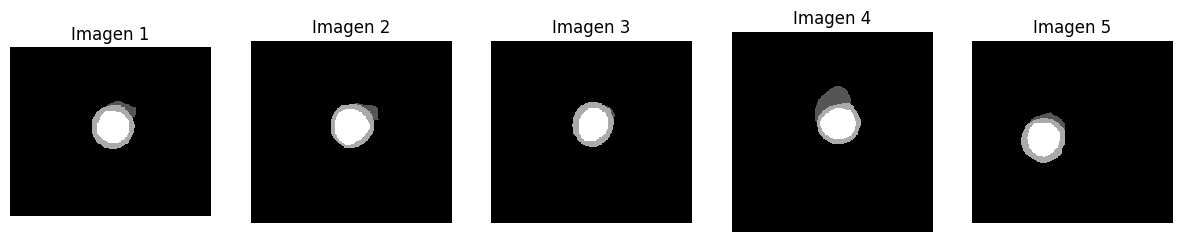

In [5]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [6]:
all_files = training_files + testing_files
images = [nib.load(file).get_fdata() for file in all_files]
image_shapes = [img.shape for img in images]
print(image_shapes)
average_shape = np.mean(image_shapes, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [7]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [8]:
from monai.data import NibabelReader

In [ ]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y esscala la intensidad de la imagen

resize_dim = (12, 128, 128)

all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="LPS"),
    # transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
    transforms.Resized(keys=["image"], spatial_size=resize_dim, mode=('nearest-exact')), 
]

In [102]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)

In [103]:
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 12, 128, 128])

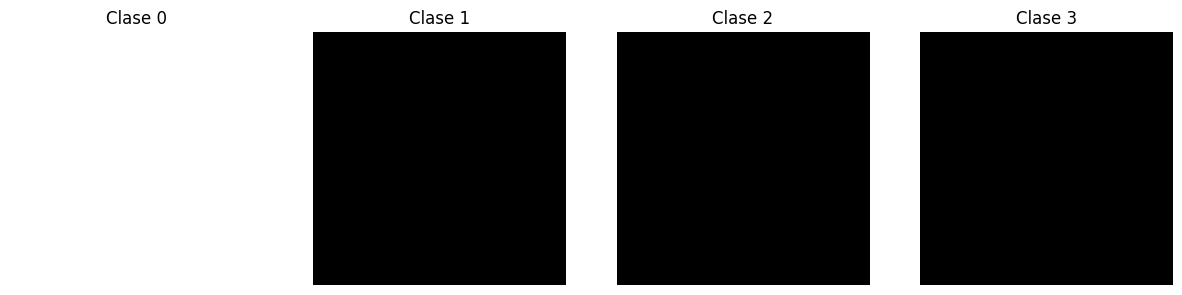

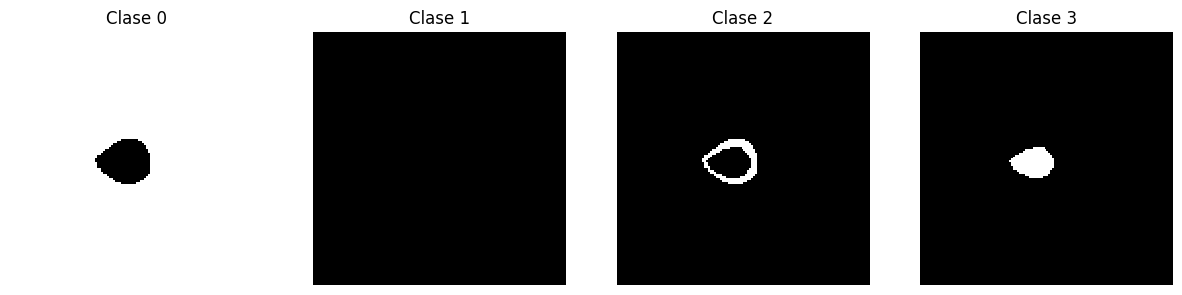

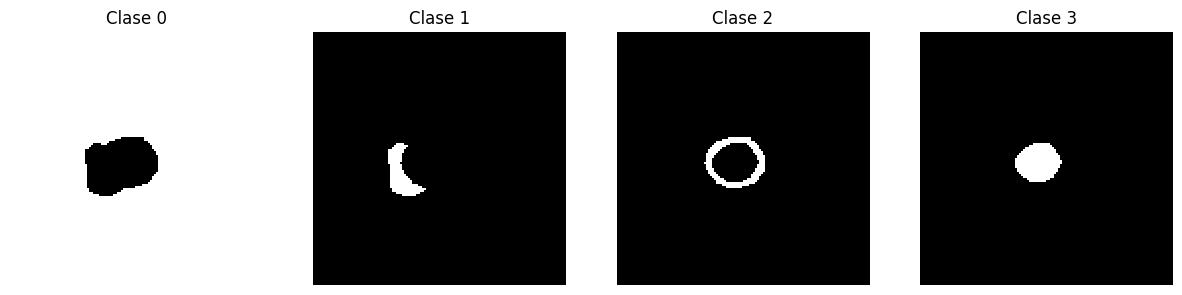

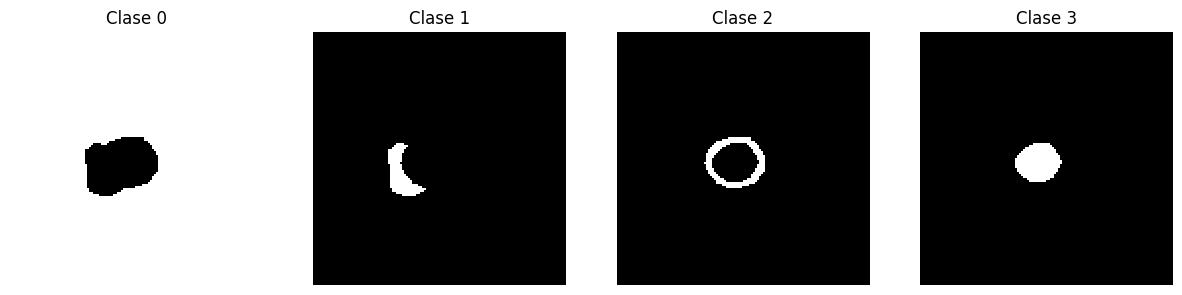

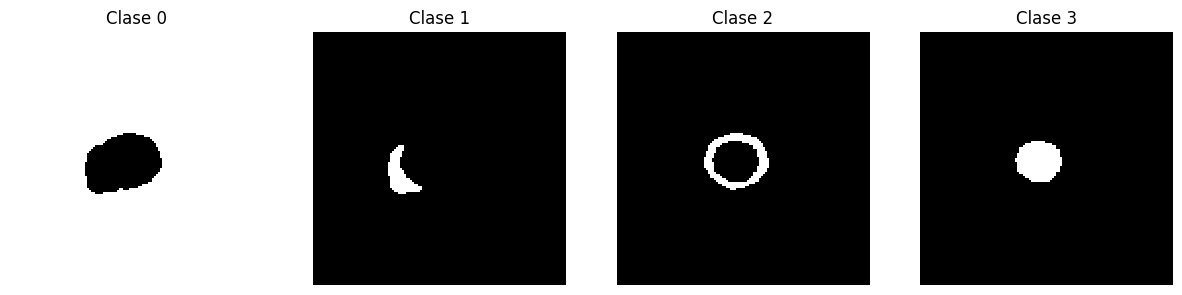

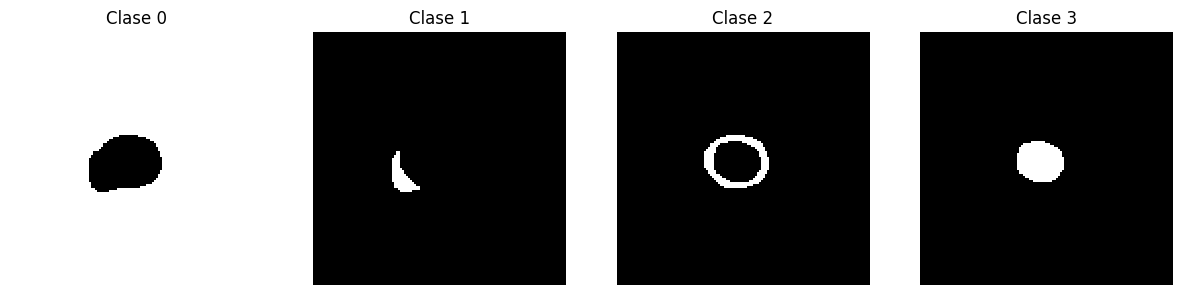

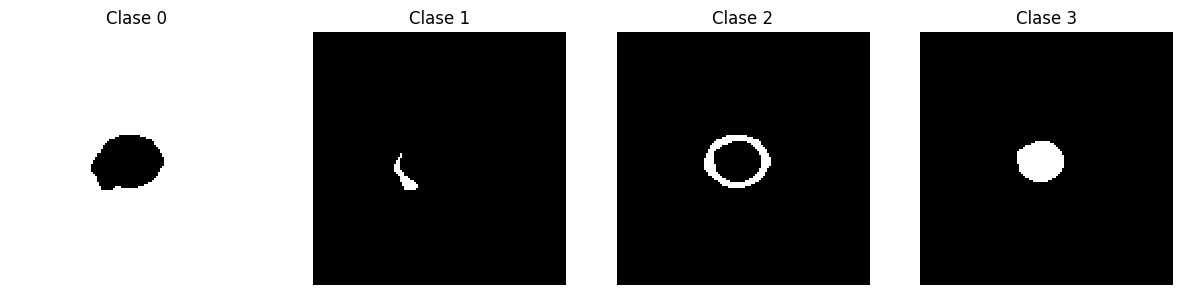

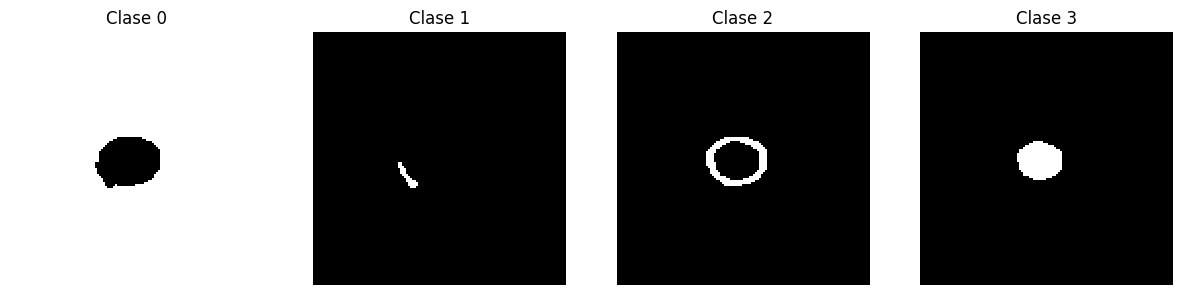

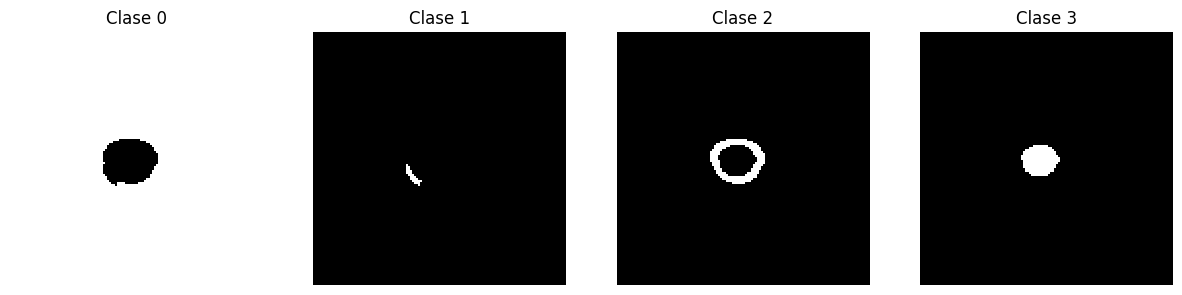

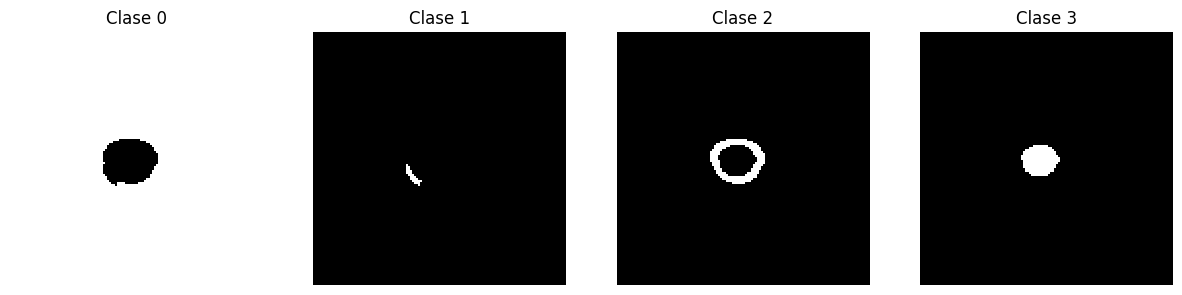

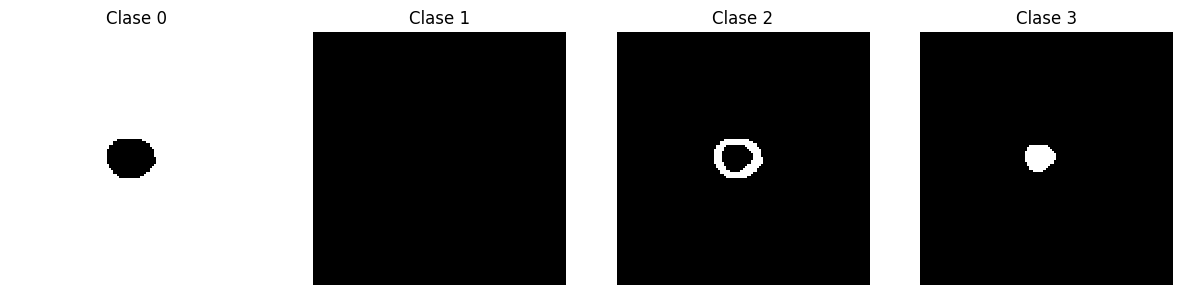

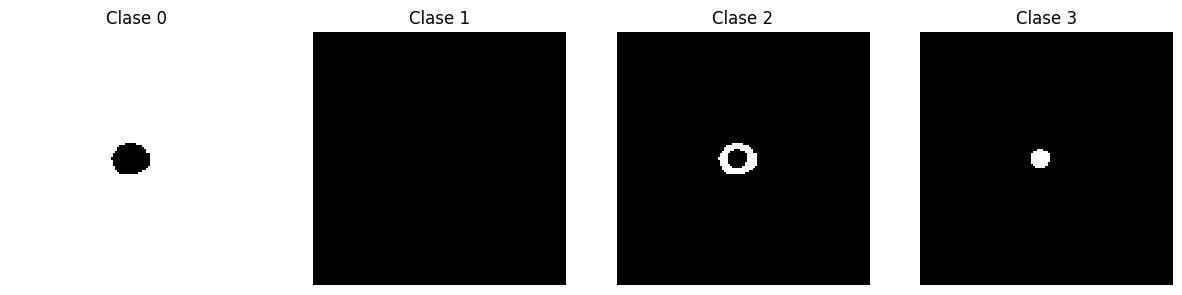

In [104]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [105]:
# # Crear un Dataset de MONAI para los archivos de entrenamiento y validación
# channel = 0  # 0 = Flair
# assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)

In [106]:
# Get one batch of validation data to visualize
first(val_loader).__getitem__("image").shape

torch.Size([1, 4, 12, 128, 128])

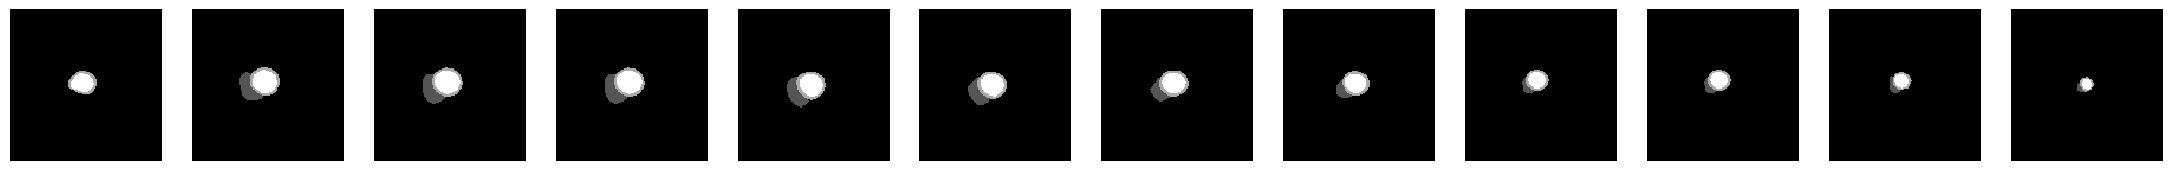

In [107]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

In [16]:
'''# Obtener los datos del primer lote del train_loader
check_data = first(train_loader)
# Select the first image from the batch
img = check_data["image"][0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[0, ..., img.shape[3] // 2].rot90(), cmap="gray")
ax = axs[1]
ax.imshow(img[0, :, img.shape[2] // 2, ...].rot90(), cmap="gray")
ax = axs[2]
ax.imshow(img[0, img.shape[1] // 2, ...].rot90(), cmap="gray")'''

'# Obtener los datos del primer lote del train_loader\ncheck_data = first(train_loader)\n# Select the first image from the batch\nimg = check_data["image"][0]\nfig, axs = plt.subplots(nrows=1, ncols=3)\nfor ax in axs:\n    ax.axis("off")\nax = axs[0]\nax.imshow(img[0, ..., img.shape[3] // 2].rot90(), cmap="gray")\nax = axs[1]\nax.imshow(img[0, :, img.shape[2] // 2, ...].rot90(), cmap="gray")\nax = axs[2]\nax.imshow(img[0, img.shape[1] // 2, ...].rot90(), cmap="gray")'

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 12, 120, 120])


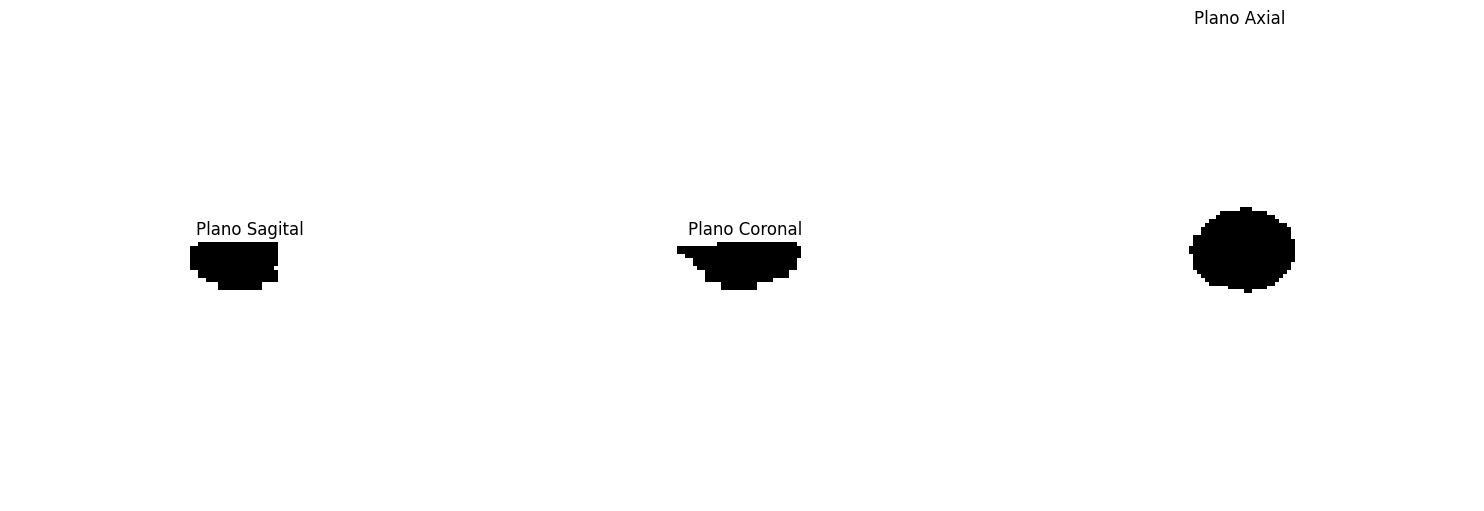

In [100]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")

# Las dimensiones son (batch, channel, width, height, depth)

width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

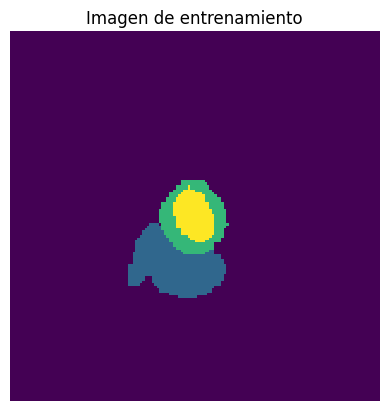

In [ ]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# Convertir el tensor en una imagen para visualizar con matplotlib
# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

## Define the network

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [108]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=(1,2,2), padding=1), # [4, 12, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 6, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),      # [16, 12, 64, 64] -> [16, 12, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 12, 128, 128] -> [4, 12, 128, 128]
        )

    def forward(self, x):
        x = self.encoder(x) # [4, 12, 128, 128] -> [1, 3, 8, 8]
        x = self.fc(x.view(x.size(0), -1)).view(x.size())
        x = self.decoder(x) # [1, 3, 8, 8] -> [4, 12, 128, 128]
        return x
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 12, 128, 128).to(device) 
sample_output = model(sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [127]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.MSELoss()

# Entrenamiento
num_epochs = 25
val_interval = 1
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_data in tqdm(train_loader):
        inputs = batch_data["image"].to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
    # Validación
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

100%|██████████| 200/200 [00:10<00:00, 18.75it/s]


Epoch [1/25], Train Loss: 0.0195
Epoch [1/25], Validation Loss: 0.0130


100%|██████████| 200/200 [00:10<00:00, 18.43it/s]


Epoch [2/25], Train Loss: 0.0100
Epoch [2/25], Validation Loss: 0.0102


100%|██████████| 200/200 [00:10<00:00, 18.31it/s]


Epoch [3/25], Train Loss: 0.0089
Epoch [3/25], Validation Loss: 0.0101


100%|██████████| 200/200 [00:10<00:00, 18.39it/s]


Epoch [4/25], Train Loss: 0.0081
Epoch [4/25], Validation Loss: 0.0105


100%|██████████| 200/200 [00:10<00:00, 18.34it/s]


Epoch [5/25], Train Loss: 0.0079
Epoch [5/25], Validation Loss: 0.0087


100%|██████████| 200/200 [00:10<00:00, 18.24it/s]


Epoch [6/25], Train Loss: 0.0077
Epoch [6/25], Validation Loss: 0.0084


100%|██████████| 200/200 [00:10<00:00, 18.27it/s]


Epoch [7/25], Train Loss: 0.0075
Epoch [7/25], Validation Loss: 0.0083


100%|██████████| 200/200 [00:10<00:00, 18.21it/s]


Epoch [8/25], Train Loss: 0.0071
Epoch [8/25], Validation Loss: 0.0090


100%|██████████| 200/200 [00:11<00:00, 18.07it/s]


Epoch [9/25], Train Loss: 0.0072
Epoch [9/25], Validation Loss: 0.0093


100%|██████████| 200/200 [00:10<00:00, 18.35it/s]


Epoch [10/25], Train Loss: 0.0069
Epoch [10/25], Validation Loss: 0.0095


100%|██████████| 200/200 [00:10<00:00, 18.47it/s]


Epoch [11/25], Train Loss: 0.0069
Epoch [11/25], Validation Loss: 0.0095


100%|██████████| 200/200 [00:11<00:00, 17.74it/s]


Epoch [12/25], Train Loss: 0.0068
Epoch [12/25], Validation Loss: 0.0086


100%|██████████| 200/200 [00:10<00:00, 18.28it/s]


Epoch [13/25], Train Loss: 0.0067
Epoch [13/25], Validation Loss: 0.0083


100%|██████████| 200/200 [00:11<00:00, 18.06it/s]


Epoch [14/25], Train Loss: 0.0066
Epoch [14/25], Validation Loss: 0.0094


100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


Epoch [15/25], Train Loss: 0.0065
Epoch [15/25], Validation Loss: 0.0080


100%|██████████| 200/200 [00:11<00:00, 17.76it/s]


Epoch [16/25], Train Loss: 0.0064
Epoch [16/25], Validation Loss: 0.0078


100%|██████████| 200/200 [00:11<00:00, 18.11it/s]


Epoch [17/25], Train Loss: 0.0062
Epoch [17/25], Validation Loss: 0.0076


100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


Epoch [18/25], Train Loss: 0.0062
Epoch [18/25], Validation Loss: 0.0085


100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [19/25], Train Loss: 0.0061
Epoch [19/25], Validation Loss: 0.0078


100%|██████████| 200/200 [00:11<00:00, 18.17it/s]


Epoch [20/25], Train Loss: 0.0061
Epoch [20/25], Validation Loss: 0.0077


100%|██████████| 200/200 [00:11<00:00, 17.71it/s]


Epoch [21/25], Train Loss: 0.0059
Epoch [21/25], Validation Loss: 0.0081


100%|██████████| 200/200 [00:11<00:00, 17.67it/s]


Epoch [22/25], Train Loss: 0.0058
Epoch [22/25], Validation Loss: 0.0076


100%|██████████| 200/200 [00:11<00:00, 17.40it/s]


Epoch [23/25], Train Loss: 0.0059
Epoch [23/25], Validation Loss: 0.0086


100%|██████████| 200/200 [00:11<00:00, 17.72it/s]


Epoch [24/25], Train Loss: 0.0061
Epoch [24/25], Validation Loss: 0.0075


100%|██████████| 200/200 [00:11<00:00, 17.93it/s]


Epoch [25/25], Train Loss: 0.0057
Epoch [25/25], Validation Loss: 0.0077


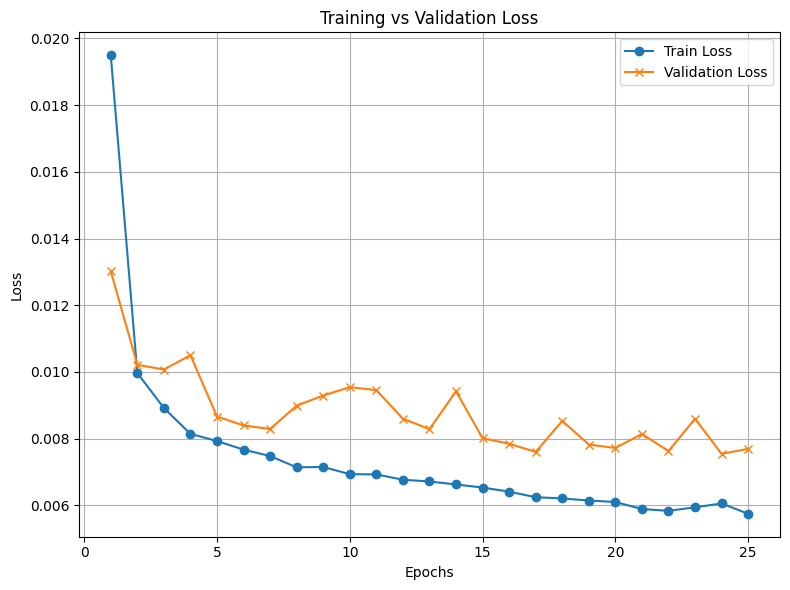

In [128]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [129]:
def visualize_axial_reconstruction(model, data_loader, device, num_images=1):

    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.eval()
    with torch.no_grad():
     
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        
        # reconstrucciones del modelo
        outputs = model(inputs)

        for i in range(min(num_images, len(inputs))):

            postprocess_input = postprocess_transform({"image": inputs})["image"]
            postprocess_output = postprocess_transform({"image": outputs})["image"]
            
            print(f"Input shape: {inputs.shape}")
            print(f"Output shape: {outputs.shape}")
            print(f"Postprocess output shape: {postprocess_output.shape}")

            plt.figure(figsize=(300, 50))
            for j in range(postprocess_output.shape[2]):
                plt.subplot(1, postprocess_output.shape[2], j + 1)
                plt.imshow(postprocess_output[i, 0, j].cpu().numpy(), cmap="gray", interpolation='none')
                plt.subplot(2, postprocess_input.shape[2], j + 1)
                plt.imshow(postprocess_input[i, 0, j].cpu().numpy(), cmap="gray", interpolation='none')
                plt.axis("off")


In [130]:
visualize_axial_reconstruction(model, val_loader, device)

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])
